In [1]:
%matplotlib notebook
from skimage.draw import circle, line_aa, set_color, random_shapes
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
MODEL_PATH = './storage/models/geolearnv3'
ZERO_THRESHOLD = 0.001

In [3]:
def noise(image, size):
    lines = np.round(np.random.rand(30, 2) * size).astype(np.int)
    for idx, item in enumerate(lines):
        if idx % 2:
            line = line_aa(0, item[0], size[0], item[1])
        else:
            line = line_aa(item[0], 0, item[1], size[1])
        rr, cc, val = line
        set_color(image, (rr, cc), np.random.rand(3), alpha=val)        

def clean_circle(size, coords, radius):
    image = np.zeros(size)
    rr, cc = circle(coords[0], coords[1], radius)
    set_color(image, (rr, cc), 1)
    return image

        
def make_example(size):
    circle_coords = np.random.rand(2)
    real_coords = circle_coords * size
    rr, cc = circle(real_coords[0], real_coords[1], 20)
    shapes, _ = random_shapes(size, shape='triangle', min_shapes=4, max_shapes=7, min_size=10)
    shapes = shapes / 255.
    example = shapes.copy()
    #example = np.ones(np.append(size, 3))
    noise(example, size)
    main_circle_color = np.random.rand(3)
    set_color(example, (rr, cc), main_circle_color)
    shapes_label = np.rollaxis(shapes, axis=-1)[0]
    shapes_label = 1. - shapes_label
    shapes_label = shapes_label > ZERO_THRESHOLD
    label = np.array([clean_circle(size, real_coords, 20), shapes_label])
    label = np.moveaxis(label, 0, 2)
    return example, label

<IPython.core.display.Javascript object>


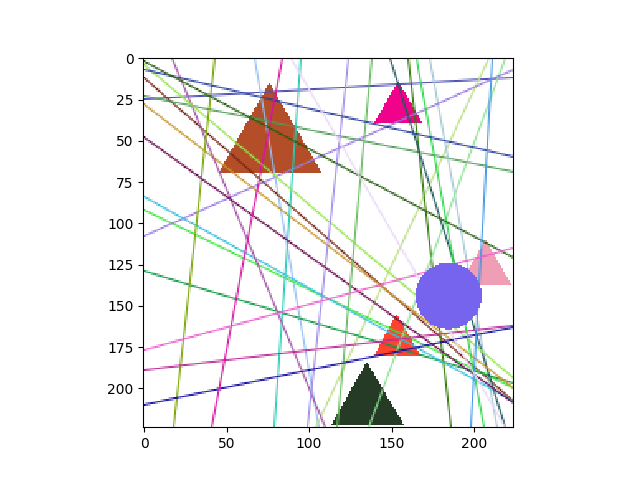

In [4]:
image, label = make_example((224, 224))
plt.imshow(image)

In [7]:
def make_examples(size, count):
    examples = [make_example(size) for _ in range(count)]
    images = np.stack(image for image, _ in examples)
    labels = np.stack(label for _, label in examples)
    return images, labels

In [5]:
def position_model_fn(features, labels, mode, config):
    layer = tf.layers.conv2d(features, filters=16, kernel_size=5, activation=tf.nn.relu, padding='same')
    layer = tf.layers.max_pooling2d(layer, 2, 2)
    
    layer = tf.layers.conv2d(layer, filters=16, kernel_size=3, activation=tf.nn.relu, padding='same')
    layer = tf.layers.max_pooling2d(layer, 2, 2)    
    
    layer = tf.layers.conv2d(layer, filters=64, kernel_size=3, activation=tf.nn.relu, padding='same')
    layer = tf.layers.max_pooling2d(layer, 2, 2)    

    layer = tf.layers.conv2d(layer, filters=64, kernel_size=1, activation=tf.nn.relu)
    layer = tf.layers.conv2d(layer, filters=64, kernel_size=1, activation=tf.nn.relu)
    
    layer = tf.layers.conv2d_transpose(layer, filters=32, kernel_size=2, strides=2, activation=tf.nn.relu)
    layer = tf.layers.conv2d_transpose(layer, filters=32, kernel_size=2, strides=2, activation=tf.nn.relu)    
    layer = tf.layers.conv2d_transpose(layer, filters=32, kernel_size=2, strides=2, activation=tf.nn.relu) 

    predictions = tf.layers.conv2d(layer, filters=2, kernel_size=1)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        spec = tf.estimator.EstimatorSpec(mode, predictions=predictions)     
    else:
        loss = tf.losses.mean_pairwise_squared_error(labels=labels, predictions=predictions)
        optimizer = tf.train.AdamOptimizer()
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        spec = tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)    
    return spec

In [8]:
size = np.array([224, 224])
batch_size = 100
eval_images, eval_labels = make_examples(size, 20)

In [9]:
position_estimator_config = tf.estimator.RunConfig(
    save_checkpoints_secs = 20*60, 
    keep_checkpoint_max = 3,
)

position_estimator = tf.estimator.Estimator(
    model_fn=position_model_fn,
    model_dir=MODEL_PATH,
    config=position_estimator_config)


INFO:tensorflow:Using config: {'_model_dir': './storage/models/geolearnv3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 1200, '_session_config': None, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc61b31fb38>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [44]:
for idx in range(10):
    print(f"Epoch {idx}")
    print("Making examples")
    train_images, train_labels = make_examples(size, 50)
    def train_dataset_fn():
        return tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(10)
    def eval_dataset_fn():
        return tf.data.Dataset.from_tensor_slices((eval_images, eval_labels)).batch(25)
    train_spec = tf.estimator.TrainSpec(input_fn=train_dataset_fn)
    eval_spec = tf.estimator.EvalSpec(input_fn=eval_dataset_fn)
    print("Training")
    tf.estimator.train_and_evaluate(position_estimator, train_spec, eval_spec)

Epoch 0
Making examples
Training
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 1200.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./storage/models/geolearnv3/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 500 into ./storage/models/geolearnv3/model.ckpt.
INFO:tensorflow:loss = 0.20592114, step = 500
INFO:tensorflow:Saving checkpoints for 505 into ./storage/models/geolearnv3/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-10-13-03:31

INFO:tensorflow:Saving checkpoints for 525 into ./storage/models/geolearnv3/model.ckpt.
INFO:tensorflow:loss = 0.21799076, step = 525
INFO:tensorflow:Saving checkpoints for 530 into ./storage/models/geolearnv3/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-10-13-03:33:37
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./storage/models/geolearnv3/model.ckpt-530
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-13-03:33:38
INFO:tensorflow:Saving dict for global step 530: global_step = 530, loss = 0.41538802
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 530: ./storage/models/geolearnv3/model.ckpt-530
INFO:tensorflow:Loss for final step: 0.12517917.
Epoch 6
Making examples
Training
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start trai

In [42]:
CATEGORY_COLORS = [
    np.array([1., 0., 0.]),
    np.array([0., 1., 0.]),
]

def label_to_image(label):
    image = np.zeros(label.shape[:2] + (3,))
    label = np.moveaxis(label, 2, 0)
    for index, color in enumerate(CATEGORY_COLORS):
        label_layer = np.repeat(label[index][:, :, np.newaxis], 3, axis=2) * color
        image += label_layer
    return image

Button(description='Check', style=ButtonStyle())

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./storage/models/geolearnv3/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


<IPython.core.display.Javascript object>


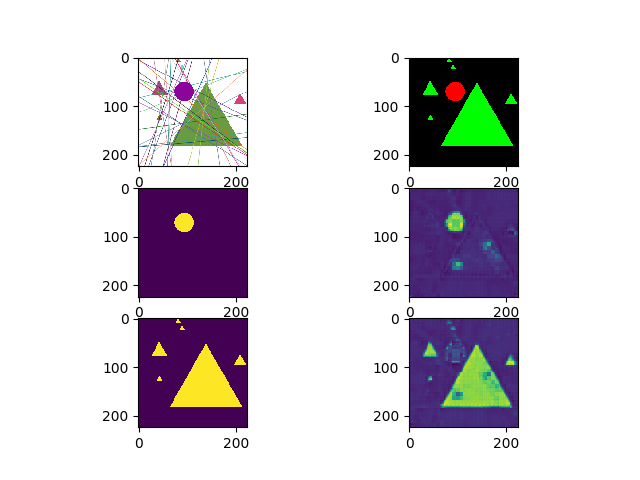

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./storage/models/geolearnv3/model.ckpt-550
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./storage/models/geolearnv3/model.ckpt-550
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./storage/models/geolearnv3/model.ckpt-550
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./storage/models/geolearnv3/model.ckpt-550
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./storage/mode

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./storage/models/geolearnv3/model.ckpt-550
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./storage/models/geolearnv3/model.ckpt-550
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./storage/models/geolearnv3/model.ckpt-550
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tenso

In [43]:
%matplotlib notebook
import ipywidgets as widgets
from IPython.display import display

def click(*args):
    images, labels = make_examples(size, 1)
    predictions = position_estimator.predict(lambda: tf.data.Dataset.from_tensor_slices((images, labels)).batch(1))
    image, label, prediction = images[0], labels[0], next(predictions)
    plt.subplot(3,2,1)
    plt.imshow(image)
    plt.subplot(3,2,2)
    plt.imshow(label_to_image(label))
    label_layers = np.moveaxis(label, 2, 0)
    prediction_layers = np.moveaxis(prediction, 2, 0)

    for idx in range(label_layers.shape[0]):
        offset = 3 + idx*2
        plt.subplot(3, 2, offset)
        plt.imshow(label_layers[idx])
        plt.subplot(3, 2, offset+1)
        plt.imshow(prediction_layers[idx])


button = widgets.Button(description='Check')
button.on_click(click)
display(button)